# LULC Classification with CNN

In [2]:
import rasterio
import rasterio.plot
from rasterio.mask import mask
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

#import torch
#from torch.utils.data import Dataset, DataLoader
#import torchvision.transforms as transforms
#import torch.nn as nn
#import torch.optim as optim

RNG_SEED = 42

In [21]:
# Optional - Used to play sound when slow cells are finished executing
from IPython.display import Audio

## Data Import

In [3]:
full_image_path = "2_CNN/input/aerial.tif"  # Aerial raster of entire area to be classified
labels_aerial_path = "2_CNN/input/aerial_512.tif" # Aerial raster of just labelled data
labels_classes_path = "2_CNN/input/labels_raster_512.tif" # Class raster of labelled data

In [4]:
# Load Full Image Aerial
with rasterio.open(full_image_path) as src:
    full_image = src.read()  # Read all bands
    full_image_meta = src.profile

# Load Classes Raster of Labelled Sample
with rasterio.open(labels_classes_path) as src:
    labels_classes = src.read(1)  # Read the first (or only) band
    labels_classes_meta = src.profile

# Load Aerial Raster of Labelled Sample
with rasterio.open(labels_aerial_path) as src:
    labels_aerial = src.read()
    labels_aerial_meta = src.profile

# Normalize image
full_image = full_image.astype(np.float32) / 255.0  # Normalize to 0-1 range if needed

# Print shapes
print("Full Image shape:", full_image.shape)  # Should be (Bands, Height, Width)
print("Labels Aerial shape:", labels_aerial.shape)
print("Labels Classes shape:", labels_classes.shape)  # Should be (Height, Width)

Full Image shape: (3, 2347, 2560)
Labels Aerial shape: (3, 512, 512)
Labels Classes shape: (512, 512)


#### ***Optional:*** *Visualize full aerial and labelled data*

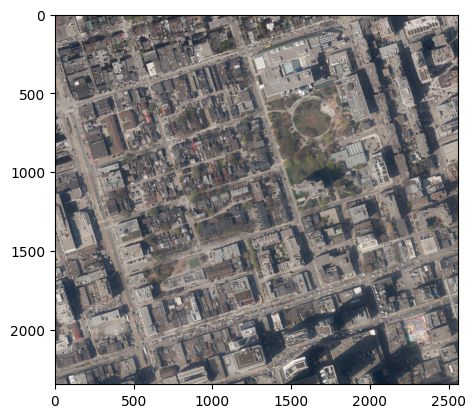

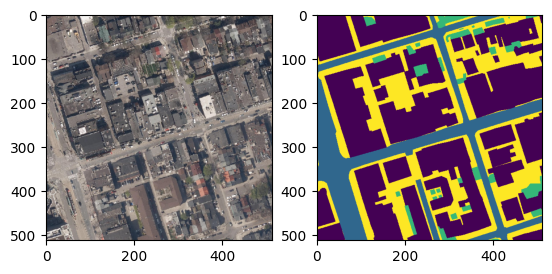

In [5]:
from rasterio.plot import reshape_as_image

# Visualize full image
rasterio.plot.show(full_image)

# Visualize lablled aerial and classes
fig, ax = plt.subplots(1,2)
ax[0].imshow(reshape_as_image(labels_aerial))
ax[1].imshow(labels_classes)

## Data Preparation

### Split Label Image into Patches

In [6]:
# Define patch size and step
patch_size = 128
patch_step = patch_size

In [31]:
from patchify import patchify

# Patchify
patches_classes = patchify(labels_classes, (patch_size, patch_size), step=patch_step) # shape (num_patches, 3, patch_size, patch_size)
patches_aerial = patchify(labels_aerial, (3, patch_size, patch_size), step=patch_step)[0] # shape (num_patches, patch_size, patch_size)

# Reshape patches into one list
X = patches_aerial.reshape(-1, 3, patch_size, patch_size) 
print(X.shape)
X = np.transpose(X, (0, 2, 3, 1)) 
print(X.shape)

Y = patches_classes.reshape(-1, patch_size, patch_size)

num_patches = X.shape[0]

print(f"Split into {num_patches} patches of size {patch_size} x {patch_size}, with step {patch_step}")
print(f"X (input) shape: {X.shape}")  # (num_patches, 3, 128, 128)
print(f"Y (labels) shape: {Y.shape}")  # (num_patches, 128, 128)

(16, 3, 128, 128)
(16, 128, 128, 3)
Split into 16 patches of size 128 x 128, with step 128
X (input) shape: (16, 128, 128, 3)
Y (labels) shape: (16, 128, 128)


#### ***Optional:*** *Visualize patches*

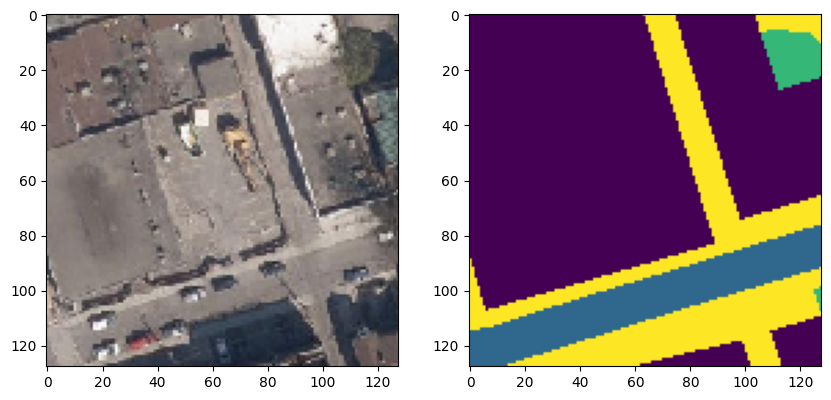

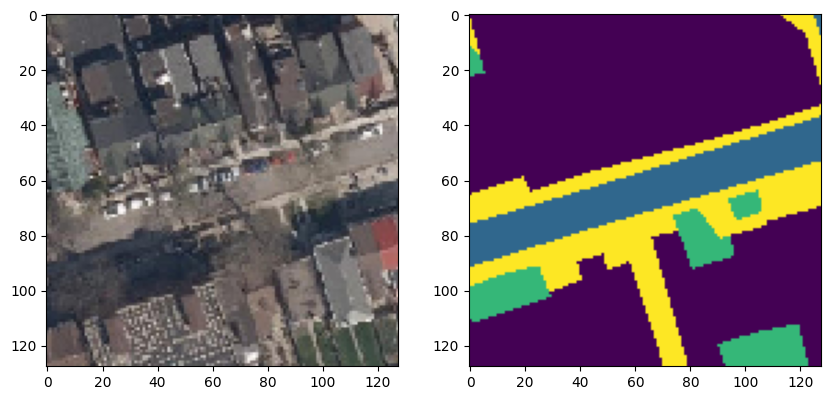

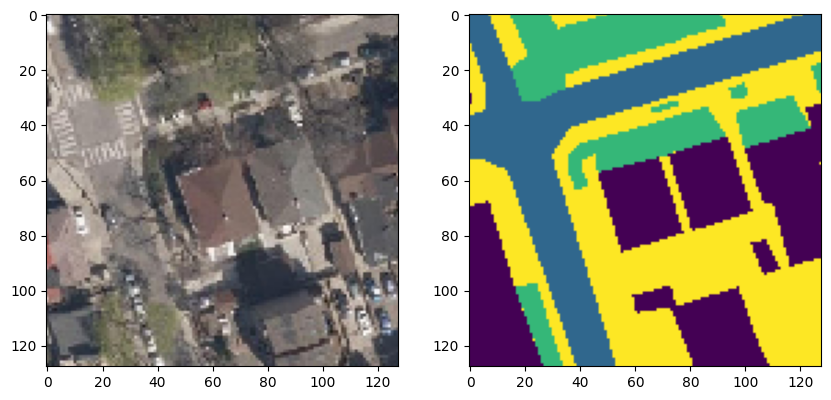

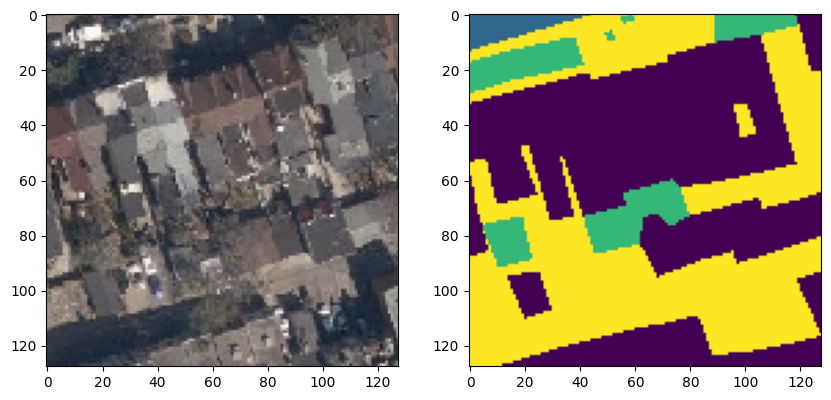

In [33]:
patches_to_show = 4 # How many patches to show (<20 recommended)
shown = 0

# Visulaize aerial raster and class raster patches next to each other
while shown < min(patches_to_show, num_patches):    
    fig, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(X[shown])
    ax[1].imshow(Y[shown])

    shown += 1

## Data Processing
### Convert Class Labels to Categorical

In [ ]:
# 0 building, 1 road, 2 vegetation, 3 alley/sidewalk/pavement

In [47]:
from tensorflow.keras.utils import to_categorical

# 1 - building, 2 - road, 3 - vegetation, 4 - alley/sidewalk/pavement
num_classes = len(np.unique(Y))

# Y classes are 1-indexed, need them 0-indexed
Y_shifted = Y - 1
# One hot encode the labels
Y_one_hot = to_categorical(Y_shifted, num_classes=num_classes)
print(f"Y (one-hot) shape: {Y_one_hot.shape}") 

Y (one-hot) shape: (16, 128, 128, 4)


### Feature Selection

### Split Training and Testing Data

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_one_hot, test_size=0.2, random_state=RNG_SEED)
print(f"Train set - X: {X_train.shape}, Y: {Y_train.shape}")
print(f"Test set -  X: {X_test.shape}, Y: {Y_test.shape}")

Train set - X: (12, 128, 128, 3), Y: (12, 128, 128, 4)
Test set -  X: (4, 128, 128, 3), Y: (4, 128, 128, 4)


## Build CNN Model


In [50]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(4, (1,1), activation='softmax')  # Output 4 classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_26 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 16, 16, 128)         │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 32, 32, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 128, 128, 4)         │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,365,924 (5.21 MB)

 Trainable params: 1,365,924 (5.21 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
history = model.fit(X_train, Y_train, epochs=20, batch_size=4, validation_data=(X_test, Y_test))


Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.1799 - loss: 11.5309 - val_accuracy: 0.1743 - val_loss: 4.7843
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3086 - loss: 2.8605 - val_accuracy: 0.6002 - val_loss: 1.1031
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.5068 - loss: 1.2138 - val_accuracy: 0.4297 - val_loss: 1.1632
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4479 - loss: 1.1862 - val_accuracy: 0.5994 - val_loss: 1.0824
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.4896 - loss: 1.1658 - val_accuracy: 0.5923 - val_loss: 1.1281
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4941 - loss: 1.1669 - val_accuracy: 0.5988 - val_loss: 1.0674
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5075 - loss: 1.1242 - val_accuracy: 0.5948 - val_loss: 1.1319
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4992 - loss: 1.1395 - val_accuracy: 0.5988 - val_loss: 1.097

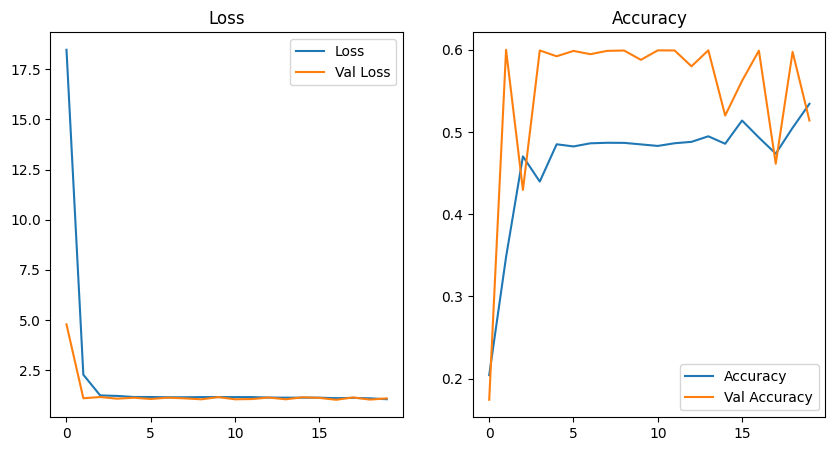

In [52]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

In [22]:
# Beep when done
beep = np.sin(2*np.pi*800*np.arange(3000*2)/10000)
Audio(beep, rate=6000, autoplay=True)

### Evaluate Accuracy

## Predict the Image